In [13]:
import numpy as np
import scipy.constants as const
import scipy.special as special
from scipy.special import erfc
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy.integrate import dblquad
import scipy.optimize as opt
import os
import math
import matplotlib as mp
import matplotlib.pyplot as plt
from numpy import ma
from matplotlib import ticker, cm
from munch import Munch

from classes import *
from user_params import *
from working_params import working_parms

In [14]:
def run_example():

    print("Hello, my name is PrimBholes. ")
    print("I am a tool to calculate the gravitational-wave predictions of primordial black holes")
    print("====")

    pu = physics_units
    wp = working_parms
    # Set merging-rate model
    myMerging = MergingRates_models

    # Set Pk model
    myPkModel = Pk_models
    # myPkModel.Pk_model = 'lognormal'
    # myPkModel.Pk_model = 'gaussian'
    # myPkModel.Pk_model = 'broken_powerlaw'
    # myPkModel.Pk_model = 'multifield'
    # myPkModel.Pk_model = 'axion_gauge'
    myPkModel.Pk_model = 'preheating'

    # Set PBH formation model
    myPBHform = 'standard'  # "Musco20"


    # set class
    myPBHFormModel = ClassPBHFormation(pm=PBHForm, Pk_model=myPkModel.Pk_model, PBHform_model=myPBHform)
    myPBHFormModel.Pkrescaling = False

    out = Munch(dict())
    # Build mode, mass and frequency vectors
    out.logmPBHtable = np.linspace(wp.logmmin, wp.logmmax, wp.Nmass)
    out.logmHtable = out.logmPBHtable - np.log10(myPBHFormModel.ratio_mPBH_over_mH)
    out.mPBHtable = 10. ** out.logmPBHtable
    out.mHtable = 10. ** out.logmHtable

    # print(type(out.logmPBHtable))

    # Compute the power spectrum P(k), beta(mPBH) and f(mPBH)
    print("Step 1:  Computation of the power spectrum P(k), the PBH density at formation (beta) and today (f_PBH)")
    print("====")
    out.ktable = myPBHFormModel.get_k(out.mPBHtable)
    out.Pktable = myPBHFormModel.get_Pk(out.ktable)
    out.logbetatable = myPBHFormModel.get_logbeta(out.mPBHtable)
    out.logfofmPBHtable = myPBHFormModel.get_logfofmPBH(out.mPBHtable)
    out.zetacrtable = myPBHFormModel.get_zetacr(out.mPBHtable)
    out.fofmPBHtable = myPBHFormModel.get_fofmPBH(out.mPBHtable)

    if (myPBHFormModel.PBHform_model == "standard"):
        print(
            "You chosed to comptute the PBH formation with the fastest standard method (fixed zeta_cr in radiation)")

    if (myPBHFormModel.PBHform_model == "Musco20"):
        print("You chosed to comptute zeta_critical with the method Musco20.  It can take several minutes...")

    out.logfPBH = myPBHFormModel.get_logfPBH(out.mPBHtable)
    out.deltacr_rad = myPBHFormModel.get_deltacr()
    out.zetacr_rad = myPBHFormModel.get_zetacr(out.mPBHtable)
    out.fPBH = 10. ** out.logfPBH

    # if (myPBHFormModel.PBHform_model == "Musco20"):
    print("delta_crit (radiation) = ", out.deltacr_rad)
    print("I get a total abundance of PBHs:  f_PBH=", out.fPBH)
    print("====")


    if myPBHFormModel.Pkrescaling:
        # Rescale the power spectrum in order to get a fixed value of f_PBH
        print("Step 1b: Rescaling of the power spectrum to get f_PBH =", myPBHFormModel.forcedfPBH)
        myPBHFormModel.Pkrescaling= True
        out.logbetatable = myPBHFormModel.get_logbeta(out.mPBHtable)
        out.logfofmPBHtable = myPBHFormModel.get_logfofmPBH(out.mPBHtable)
        out.zetacrtable = myPBHFormModel.get_zetacr(out.mPBHtable)
        out.fofmPBHtable = myPBHFormModel.get_fofmPBH(out.mPBHtable)
        out.logfPBH = myPBHFormModel.get_logfPBH(out.mPBHtable)
        out.deltacr_rad = myPBHFormModel.get_deltacr()
        out.zetacr_rad = myPBHFormModel.get_zetacr(out.mPBHtable)
        out.fPBH = 10. ** out.logfPBH
        print("After rescaling, I get a total abundance of PBHs: fPBH=", out.fPBH)
        print("Rescaling factor=", myPBHFormModel.Pkscalingfactor)
        print("zeta_crit (radiation) = ", out.deltacr_rad)
        print("====")


    # print self.logfofmPBHtable
    out.ratiodeltacrtable =  out.zetacr_rad / out.deltacr_rad
    # print self.ratiodeltacrtable

    # Compute the SGWB from 2nd order perturbations
    print("Step 2:  Computation of the GW spectrum from denstiy perurbations at second order")
    print("Can take several minutes depending on the value of nk...")
    print("====")

    ks = myPkModel.kp / pu.mpc * pu.c
    sigmaps = 0.5
    print("ks = ", ks)

    kvals = np.logspace(np.log10(wp.kmin), np.log10(wp.kmax), wp.nk)
    # print self.Pk(kvals * self.mpc /self.c) * self.Pkscalingfactor
    # print "coucou 2nd order GW"
    kres = np.array([myPBHFormModel.compint(xi, sigmaps) for xi in kvals])   #TODO: set compint to new class
    # coefficient due to thermal history see Eq. (2.11) https://arxiv.org/pdf/1810.12224.pdf
    # to be updated depending on the reference peak of the spectrum, to integrated with the rest of the code
    Omega_r_0 = 2.473 * 1e-5
    norm = myPBHFormModel.ratio_mPBH_over_mH * Omega_r_0 / 972.

    out.freq_2ndOmGW = ks * kvals / 2. / np.pi
    # print "Second coucou 2nd order GW"
    out.OmGW_2ndOmGW = norm * kres

    out.ztable = np.linspace(wp.zmin, wp.zmax, wp.Nz)


    # Compute the merging rates
    print("Step 3:  Computation of the PBH merging rates")
    print("====")
    out.rate_prim = np.zeros((wp.Nmass, wp.Nmass))
    out.rate_clust = np.zeros((wp.Nmass, wp.Nmass))

    if myMerging.primordial.wanted == True:
        out.rate_prim = myPBHFormModel.rates_primordial(out.mPBHtable, out.fofmPBHtable)   #TODO: set compint to new class
        print("Merging rates of primordial binaries have been calculated")
        print("====")

    if myMerging.clusters.wanted == True:
        out.rate_clust = myPBHFormModel.rates_clusters(out.mPBHtable, out.fofmPBHtable)         #TODO: set compint to new class
        print("Merging rates of binaries formed by capture in clusters have been calculated")
        print("====")

    print("End of code, at the moment...  Thank you for having used PrimBholes")

    return out

In [15]:
out = run_example()

######

figPk = plt.figure()
figPk.patch.set_facecolor('white')
ax = figPk.add_subplot(111)
ax.plot(out.ktable,out.Pktable,label='P(k)')
plt.title("Primoridal power sepctrum")
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1.e-10,10.)
plt.xlabel('Wavenumber $k$ [Mpc$^{-1}$]')
plt.ylabel(r'$\mathcal{P}_{\zeta} (k)$')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

figzetacr = plt.figure()
figzetacr.patch.set_facecolor('white')
ax = figzetacr.add_subplot(111)
ax.plot(out.mHtable,out.ratiodeltacrtable,color='orange')
#ax.plot(out.mHtable,out.ratiodeltacrtable,label=r'$\zeta_{c}$',color='orange')
plt.title("Denstiy threshold")
ax.set_xscale('log')
plt.ylim(0.85,1.05)
plt.xlabel(r'$m_{H} [M_\odot]$')
plt.ylabel(r'$\delta_c / \delta_c^{rad}$')
#plt.legend(loc='upper left')
plt.grid(True)
figzetacr.savefig(figdir + '/deltacr.png',facecolor=figzetacr.get_facecolor(), edgecolor='none',dpi=600)
plt.show()

figbeta = plt.figure()
figbeta.patch.set_facecolor('white')
ax = figbeta.add_subplot(111)
ax.plot(out.mPBHtable,10.**out.logbetatable,label=r'$\beta(m_{PBH})$',color='red')
plt.title("PBH denstiy distribution at formation")
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1.e-15,1.e-8)
plt.xlabel(r'$m_{PBH} [M_\odot]$')
plt.ylabel(r'$\beta(m_{PBH})$')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

figfPBH = plt.figure()
figfPBH.patch.set_facecolor('white')
ax = figfPBH.add_subplot(111)
ax.plot(out.mPBHtable, 10.** out.logfofmPBHtable,label=r'$f(m_{PBH})$',color='black')
plt.title("PBH density distribution today")
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(1.e-4,1.e1)
plt.xlabel(r'$m_{PBH} [M_\odot]$')
plt.ylabel(r'$f_{PBH}$')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

fig2ndOmGW = plt.figure()
fig2ndOmGW.patch.set_facecolor('white')
ax = fig2ndOmGW.add_subplot(111)
ax.plot(out.freq_2ndOmGW,out.OmGW_2ndOmGW,label=r'$\Omega_{GW}^{\mathrm{2nd Order}}$',color='green')
plt.title("SGWB from 2nd order perturbations")
ax.set_xscale('log')
ax.set_yscale('log')
#plt.ylim(1.e-4,1.e1)
plt.xlabel(r'$f [Hz]$')
plt.ylabel(r'$\Omega_{GW}$')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()



figRprim = plt.figure()
figRprim.patch.set_facecolor('white')
ax = figRprim.add_subplot(111)
zscale = ma.masked_where(out.rate_prim <= 0, out.rate_prim)
cs = ax.contourf(out.logmPBHtable,out.logmPBHtable, np.transpose(zscale), locator=ticker.LogLocator()) #, cmap=cm.PuBu_r)
plt.title("Merging rates for primordial binaries")
cbar = figRprim.colorbar(cs)
cbar.set_label(r'$yr^{-1}Gpc^{-3}$', rotation=90)
plt.xlabel(r'$\log \, m_1 /M_\odot $')
plt.ylabel(r'$\log \, m_2 /M_\odot $')
plt.grid(True)
figRprim.savefig(figdir + '/Rprim.png', facecolor=figRprim.get_facecolor(), edgecolor='none', dpi=600)
plt.show()

figRclust = plt.figure()
figRclust.patch.set_facecolor('white')
ax = figRclust.add_subplot(111)
zscale = ma.masked_where(out.rate_clust <= 0, out.rate_clust)
cs=ax.contourf(out.logmPBHtable,out.logmPBHtable, np.transpose(zscale), locator=ticker.LogLocator())
plt.title("Merging rates for tidal capture in clusters")
cbar = figRclust.colorbar(cs)
cbar.set_label(r'$yr^{-1}Gpc^{-3}$', rotation=90)
plt.xlabel(r'$\log \, m_1 /M_\odot $')
plt.ylabel(r'$\log \, m_2 /M_\odot $')
plt.grid(True)
figRclust.savefig(figdir + '/Rclust.png',facecolor=figRclust.get_facecolor(), edgecolor='none',dpi=600)
plt.show()


Hello, my name is PrimBholes. 
I am a tool to calculate the gravitational-wave predictions of primordial black holes
====
FormPBH (class) set  PBHform_model to  standard
FormPBH (class) set  Pk to  preheating
Step 1:  Computation of the power spectrum P(k), the PBH density at formation (beta) and today (f_PBH)
====


ValueError: A value in x_new is below the interpolation range.

====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  lognormal
====


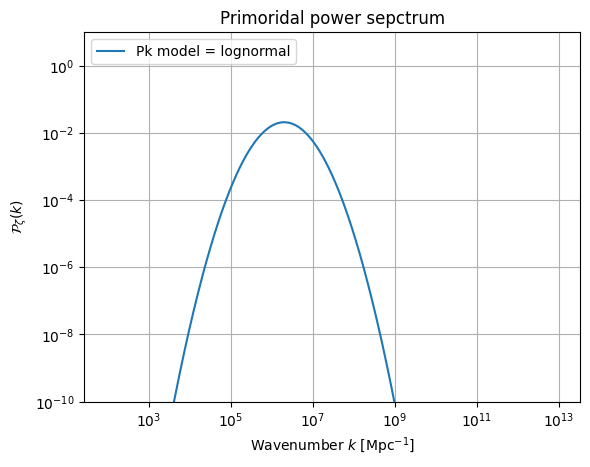

====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  gaussian
====


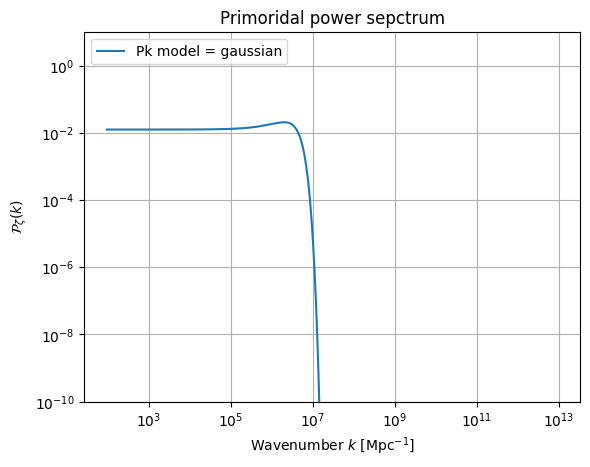

====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  broken_powerlaw
====


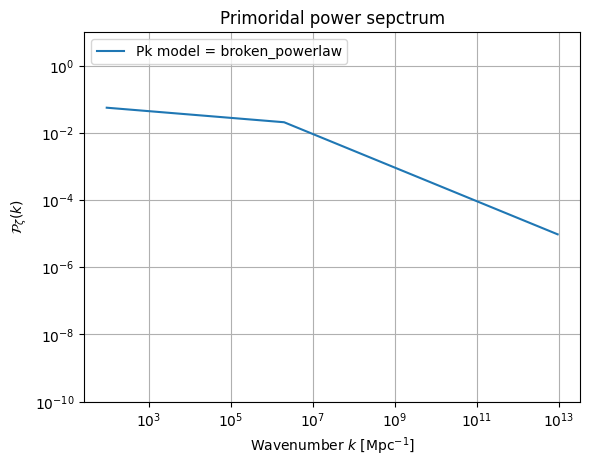

====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  multifield
====


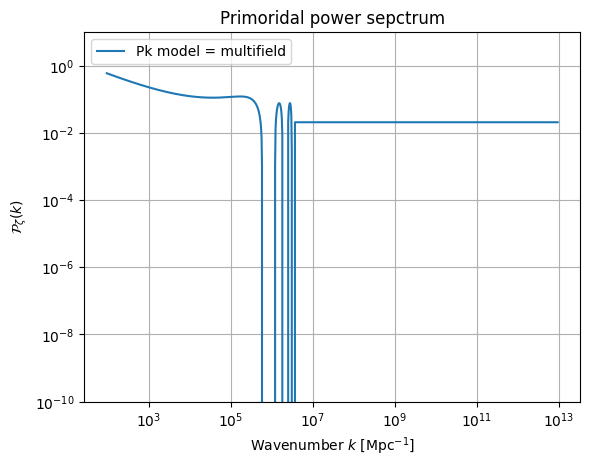

====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  axion_gauge
====


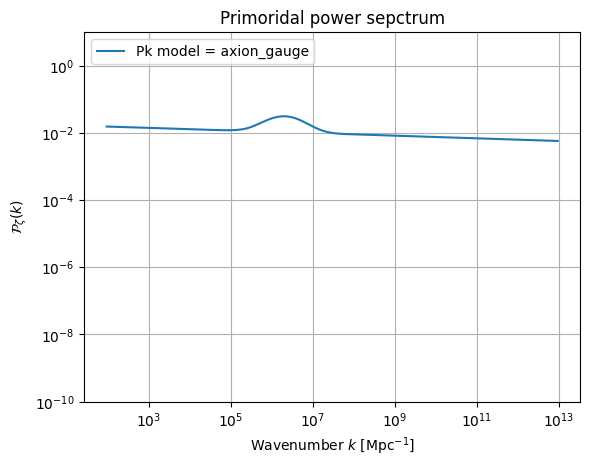

====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  preheating
====


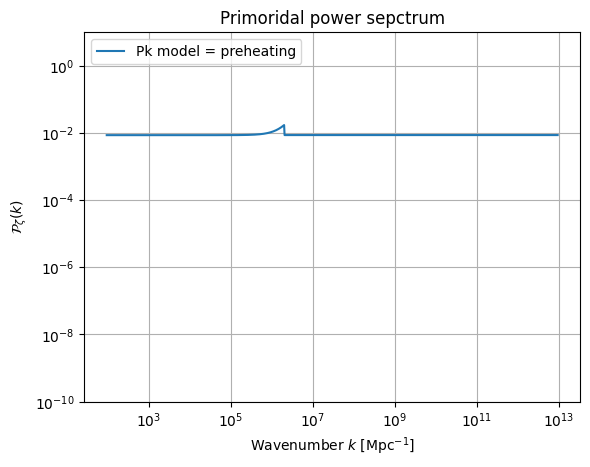

In [ ]:
models = [ 
    'lognormal',
    'gaussian',
    'broken_powerlaw',
    'multifield',
    'axion_gauge',
    'preheating'
]



def pk_example(model):

    print("====")

    pu = physics_units
    wp = working_parms
    # Set merging-rate model
    myMerging = MergingRates_models

    # Set Pk model
    myPkModel = Pk_models
    myPkModel.Pk_model = model


    # set class
    myPBHFormModel = ClassPBHFormation(pm=PBHForm, Pk_model=myPkModel.Pk_model)
    myPBHFormModel.Pkrescaling = False
    
    out = Munch(dict())
    # Build mode, mass and frequency vectors
    out.logmPBHtable = np.linspace(wp.logmmin, wp.logmmax, wp.Nmass)
    out.logmHtable = out.logmPBHtable - np.log10(myPBHFormModel.ratio_mPBH_over_mH)
    out.mPBHtable = 10. ** out.logmPBHtable

    print("====")
    out.ktable = myPBHFormModel.get_k(out.mPBHtable)
    out.Pktable = myPBHFormModel.get_Pk(out.ktable)

    out.params = Munch(dict())
    out.params.pk_model = model

    return out



######

def plot_pk(out):
    
    model = out.params.pk_model

    figPk = plt.figure()
    figPk.patch.set_facecolor('white')
    ax = figPk.add_subplot(111)
    lbl = "Pk model = {}".format(model)
    ax.plot(out.ktable,out.Pktable,label=lbl)
    plt.title("Primoridal power sepctrum")
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylim(1.e-10,10.)
    plt.xlabel('Wavenumber $k$ [Mpc$^{-1}$]')
    plt.ylabel(r'$\mathcal{P}_{\zeta} (k)$')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
    
    return plt, ax

    
for model in models:

    out = pk_example(model)
    plot_pk(out)


## Plot power spectra models

In [ ]:
import matplotlib as mpl 

#Specify the plot style
mpl.rcParams.update({'font.size': 10,'font.family':'serif'})
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rc('text', usetex=True)

mpl.rcParams['legend.edgecolor'] = 'inherit'

====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  powerlaw
====
====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  powerlaw
====
====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  broken_powerlaw
====
====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  lognormal
====
====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  gaussian
====
====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  multifield
====
====
FormPBH (class) set  PBHform_model to  Musco20
FormPBH (class) set  Pk to  axion_gauge
====


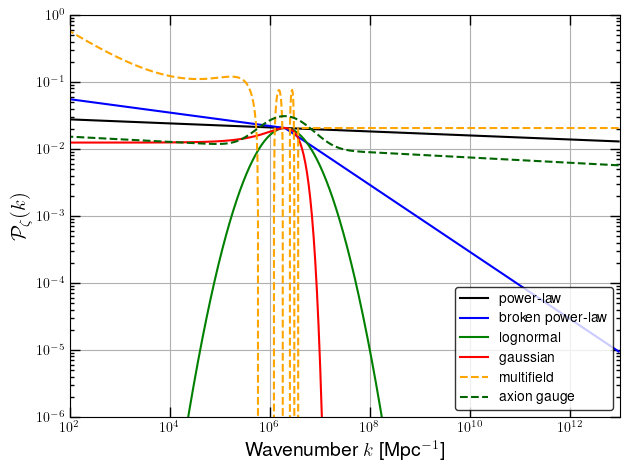

(<module 'matplotlib.pyplot' from '/home/cjoana/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>,
 <AxesSubplot: xlabel='Wavenumber $k$  [Mpc$^{-1}$]', ylabel='$\\mathcal{P}_{\\zeta} (k)$'>)

In [23]:
models = [ 
    'powerlaw',
    'broken_powerlaw',
    'lognormal',
    'gaussian',
    'multifield',
    'axion_gauge',
#     'preheating'
]

model_name = [
    'power-law',
    'broken power-law',
    'lognormal',
    'gaussian',
    'multifield',
    'axion gauge',
#     'preheating'   #   (2.20)
    
]

color_pal = ['k', 'b', 'g', 'r',  'orange', 'darkgreen', 'purple']
lstyle = ['-', '-', '-', '-',      '--', '--', '--']

# import user_params
# importlib.reload(user_params)

from matplotlib import rc
rc("font",**{'family':'sans-serif','sans-serif':['Helvetica']})


# Pk_models.powerlaw.AsPBH = 0.01 * 0.0205     # Power spectrum amplitude at the reference scale kp.

def pk_example(model):

    print("====")

    pu = physics_units
    wp = working_parms
    # Set merging-rate model
#     myMerging = MergingRates_models

    # Set Pk model
    myPkModel = Pk_models
    myPkModel.Pk_model = model

    
    # set class
    myPBHFormModel = ClassPBHFormation(pm=PBHForm, Pk_model=myPkModel.Pk_model)
    myPBHFormModel.Pkrescaling = False
    
    out = Munch(dict())
    # Build mode, mass and frequency vectors
    out.logmPBHtable = np.linspace(wp.logmmin, wp.logmmax, wp.Nmass)
    out.logmHtable = out.logmPBHtable - np.log10(myPBHFormModel.ratio_mPBH_over_mH)
    out.mPBHtable = 10. ** out.logmPBHtable

    print("====")
    out.ktable = myPBHFormModel.get_k(out.mPBHtable)
    out.Pktable = myPBHFormModel.get_Pk(out.ktable)

    out.params = Munch(dict())
    out.params.pk_model = model

    return out



######

# def plot_pk(out):
    
#     model = out.params.pk_model

#     figPk = plt.figure()
#     figPk.patch.set_facecolor('white')
#     ax = figPk.add_subplot(111)
#     lbl = "Pk model = {}".format(model)
#     ax.plot(out.ktable,out.Pktable,label=lbl)
# #     plt.title("Primoridal power sepctrum")
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     plt.ylim(1.e-10,10.)
#     plt.xlabel('Wavenumber $k$ [Mpc$^{-1}$]')
#     plt.ylabel(r'$\mathcal{P}_{\zeta} (k)$')
#     plt.legend(loc='upper left')
#     plt.grid(True)
#     plt.show()
    
#     return plt, ax


    
for i, model in enumerate(models):

    if i >0: break
    out = pk_example(model)
#     plot_pk(out)

    

    
def plot_SingleFigure():
    
    figPk = plt.figure()
    figPk.patch.set_facecolor('white')
    ax = figPk.add_subplot(111)
        
    for i, model in enumerate(models):
        out = pk_example(model)
        model = out.params.pk_model        
        lbl = "{}".format(model_name[i])
        ax.plot(out.ktable,out.Pktable,label=lbl, color=color_pal[i], ls=lstyle[i])
        
#     plt.title("Primoridal power sepctrum")
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylim(1.e-6,1e0)
    plt.xlim(1e2,1e13)
    plt.xlabel('Wavenumber $k$  [Mpc$^{-1}$]', fontsize=14)
    plt.ylabel(r'$\mathcal{P}_{\zeta} (k)$', fontsize=15)
    
    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("powerspectrum_models.png")
    plt.show()
    
    return plt, ax

plot_SingleFigure()